# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

import math
import os
import pprint
from itertools import combinations
from pathlib import Path

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.display import HTML, Markdown, clear_output
from sklearn import datasets, decomposition
from tqdm.auto import tqdm

In [2]:
from example_aencoders import autoencoder_factory

from polcanet import PolcaNet

In [3]:
np.random.seed(5)

In [4]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

### Load iris dataset

In [5]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

### Fit standard sklearn PCA

In [6]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
Xpca = pca.transform(X)
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

### Fit POLCANet

In [22]:
ae_input = X
act_fn = torch.nn.Mish()

aencoder_iris = autoencoder_factory(
    input_dim=ae_input.shape[1],
    latent_dim=ae_input.shape[1],
    hidden_dim=256,
    num_layers=1,
    autoencoder_type="dense",
    act_fn=act_fn,
)

model_iris = PolcaNet(
    model=aencoder_iris,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=0.1,  # variance reduction loss
    device="cuda:0",
)
model_iris

PolcaNet(
  (model): BaseAutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=4, out_features=256, bias=True)
      (1): Mish()
      (2): Linear(in_features=256, out_features=4, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=4, bias=True)
    )
  )
  (reconstruction_loss_fn): MSELoss()
)

In [23]:
model_iris.to("cuda:0")
model_iris.train_model(data=X, batch_size= 512, num_epochs=10000, report_freq=100, lr=1e-3)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
loss: 0.06502
decode: 0.0007797
orth: 0.5078
com: 0.006922
var: 0.06522


In [24]:
model_iris.train_model(data=X, batch_size= 512, num_epochs=10000, report_freq=100, lr=1e-4)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
loss: 0.06448
decode: 0.0008272
orth: 0.506
com: 0.006328
var: 0.06716


## Evaluate results

In [25]:
latents, reconstructed = model_iris.predict(X)

In [26]:
model_iris.analyze_latent_space(latents=latents)


           Latent Space Analysis Report           

1. General Information
------------------------------
Number of latent components: 4
Total variance in latent space: 2.8853

2. Variance Analysis
------------------------------
Metric                           Value
-----------------------------  -------
First component                 0.9009
First 5 components              1
Components for 95% variance     2
Variance Concentration Metric   0.9751

Variance Concentration Interpretation:
Excellent concentration of variance in earlier dimensions.

3. Orthogonality Analysis
------------------------------
Metric                                 Value
-----------------------------------  -------
Mean absolute off-diagonal            0.0547
Median absolute off-diagonal          0.0195
Max absolute off-diagonal             0.2435
Proportion of |Orthogonality| > 0.1   0.1667
Orthogonality Success Metric          0.9453

Orthogonality Interpretation:
Excellent orthogonality of features.

4. De

/data/conda/envs/python3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/conda/envs/python3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


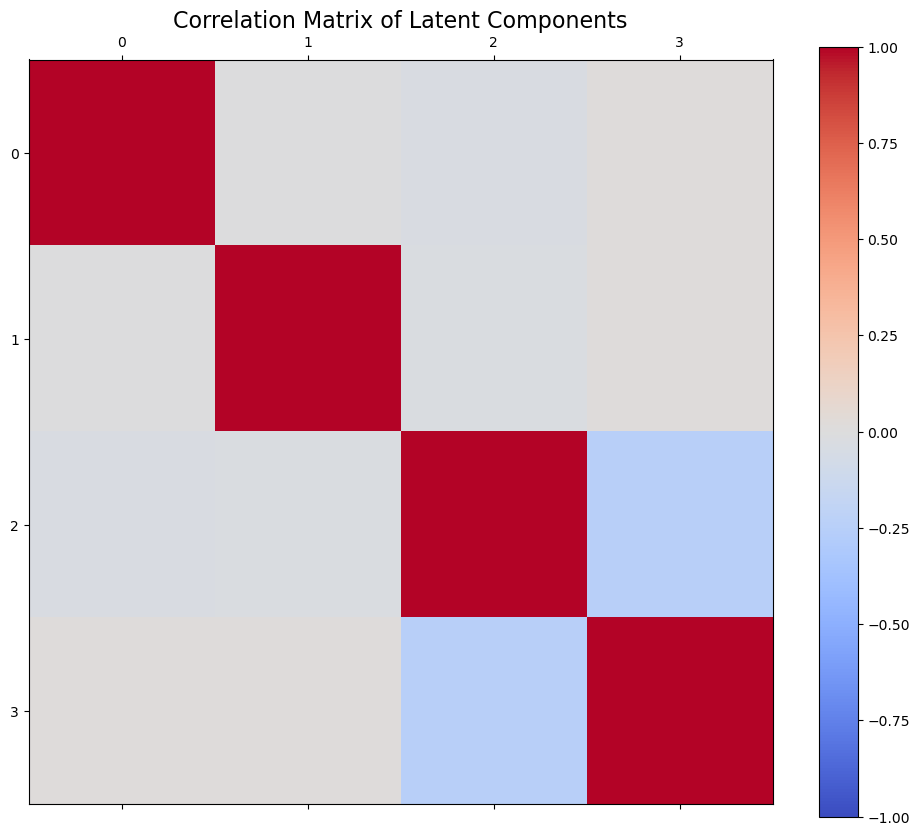

In [27]:
model_iris.show_correlation_matrix(latents)

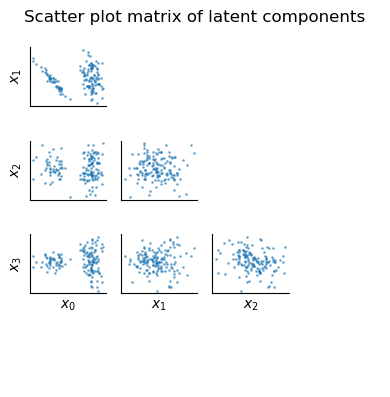

In [28]:
model_iris.plot_scatter_corr_matrix(latents)

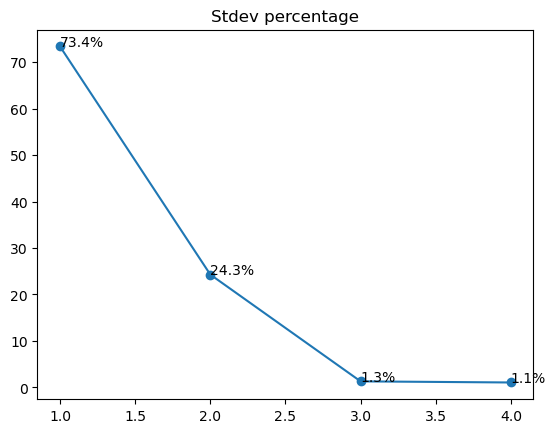

In [29]:
model_iris.plot_stdev_pct()

(1) reconstruction error: 0.2997, variance: 92.5%, with      1  active latent components
(2) reconstruction error: 0.0302, variance: 99.4%, with      2  active latent components
(3) reconstruction error: 0.0204, variance: 99.6%, with      3  active latent components
(4) reconstruction error: 0.0009, variance: 100.0%, with      4  active latent components


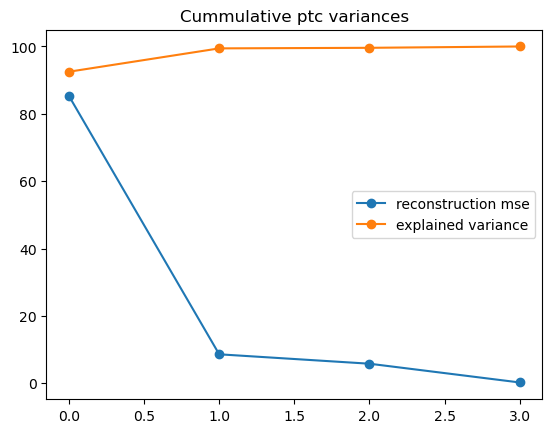

In [30]:
model_iris.plot_cumsum_variance(X)

### Polca Net vs. PCA

In [31]:
def plot2d_analysis(X, y, title, legend=True):
    fig = plt.figure(1, figsize=(5, 5))
    ax = fig.add_subplot(111)

    for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
        ax.scatter(X[y == label, 0], X[y == label, 1], label=name)
        ax.set_xlabel("component: 0")
        ax.set_ylabel("component 1")

        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
    if legend:
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()
    return fig, ax

In [32]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    fig, ax = plot2d_analysis(Xpca, y, title="PCA transform", legend=True)
with o2:
    fig, ax = plot2d_analysis(latents, y, title="POLCA-Net latent")
layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

In [33]:
o1 = widgets.Output()
o2 = widgets.Output()
o3 = widgets.Output()
o4 = widgets.Output()

with o1:
    fig1, ax1 = plot2d_analysis(X, y, "Original data two first componets", legend=False)

with o2:
    fig2, ax2 = plot2d_analysis(pca.inverse_transform(Xpca), y, "Reconstructed with PCA two componets", legend=False)

with o3:
    latents, reconstructed = model_iris.predict(X, np.array([1, 1, 0, 0]))
    fig3, ax3 = plot2d_analysis(np.round(reconstructed, 1), y, title="Reconstructed with POLCA two componets", legend=False)

with o4:
    latents, reconstructed = model_iris.predict(X, np.array([1, 1, 1, 1]))
    fig4, ax4 = plot2d_analysis(np.round(reconstructed, 1), y, title="Reconstructed with POLCA all componets", legend=False)


layout = widgets.Layout(grid_template_columns="repeat(2, 450px)")
accordion = widgets.GridBox(children=[o1, o2, o3, o4], layout=layout)
display(accordion)

GridBox(children=(Output(), Output(), Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 450p…

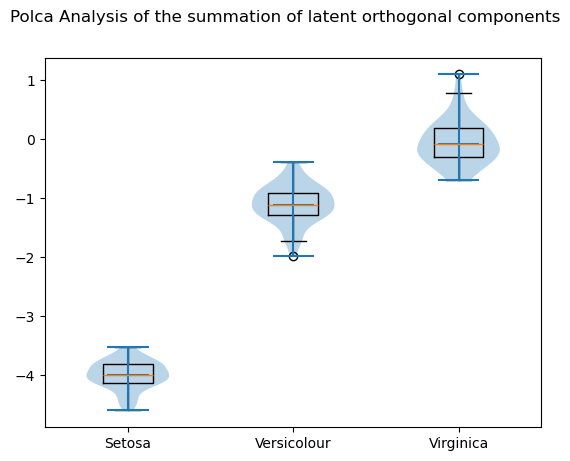

In [34]:
latents, reconstructed = model_iris.predict(X)
vectors = []
labels = ["Setosa", "Versicolour", "Virginica"]
for c, label in enumerate(labels):
    vectors.append(np.sum(latents[y == c, :], axis=1))


plt.boxplot(vectors, labels=labels)
plt.violinplot(vectors, showmeans=False, showmedians=True)
plt.suptitle("Polca Analysis of the summation of latent orthogonal components")
plt.show()

In [35]:
import seaborn as sns

o1 = widgets.Output()
o2 = widgets.Output()
idx = np.arange(latents.shape[1])
idx = -1

with o1:
    scores = model_iris.score(X)
    sns.displot(scores, kde=True)
    plt.title("Last componet with clean data")
    plt.show()

with o2:
    scores = model_iris.score(X * (np.random.random(size=X.shape) - 0.5) * 1)
    sns.displot(scores, kde=True)
    plt.title("Last componet with uniform noise in data")
    plt.show()


layout = widgets.Layout(grid_template_columns="repeat(2, 500px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 500px)'))

In [36]:
model_iris.std_metrics

array([1.612289  , 0.53340244, 0.02829473, 0.02303426], dtype=float32)

In [37]:
model_iris.mean_metrics

array([-0.9805785 , -0.09099481, -0.5476929 , -0.09968674], dtype=float32)

In [60]:
def generate_2d_sinusoidal_data(N, M, num_samples):
    data = []
    for _ in range(num_samples):
        x = np.linspace(0, 1, N)
        y = np.linspace(0, 1, M)
        xx, yy = np.meshgrid(x, y)

        # Random phase shifts for x and y directions
        phase_shift_x = np.random.uniform(0, 2 * np.pi)
        phase_shift_y = np.random.uniform(0, 2 * np.pi)

        # Random frequency multipliers for x and y directions
        freq_multiplier_x = np.random.uniform(0.5, 1.5)
        freq_multiplier_y = np.random.uniform(0.5, 1.5)

        # Generate sinusoidal data with random phase and frequency
        z = np.sin(2 * np.pi * freq_multiplier_x * xx + phase_shift_x) * np.cos(2 * np.pi * freq_multiplier_y * yy + phase_shift_y)
        data.append(z)

    return np.array(data).astype(np.float32)

In [61]:
# Parameters
N = 32  # Sequence length
M = 32  # Number of features
num_samples = 1000

# Generate 2D sinusoidal data
data = generate_2d_sinusoidal_data(N, M, num_samples)
data.shape

(1000, 32, 32)

In [62]:
# model = PolcaNet(
#     input_dim=M,
#     latent_dim=256,
#     hidden_dim=None,
#     num_layers=1,
#     autoencoder_type="lstm",
#     seq_len=N,
#     alpha=1.0,  # ortgogonality loss
#     beta=1.0,  # variance sorting loss
#     gamma=1.0,  # variance reduction loss
#     device="cuda",
# )


aencoder_lstm = autoencoder_factory(
    input_dim=M,
    latent_dim=256,
    hidden_dim=None,
    num_layers=3,
    autoencoder_type="lstm",
    seq_len=N,
    act_fn=act_fn,
)

model_lstm = PolcaNet(
    model=aencoder_lstm,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda",
)

In [ ]:
model_lstm.to_device("cuda")
model_lstm.train_model(data=data, batch_size=512, num_epochs=20000, report_freq=10, lr=0.001)

In [118]:
aencoder_conv2d = autoencoder_factory(
    input_dim=M,
    latent_dim=64,
    hidden_dim=None,
    num_layers=None,
    autoencoder_type="conv2d",
    seq_len=N,
)

model = PolcaNet(
    model=aencoder_conv2d,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=0.1,  # variance reduction loss
    device="cuda",
)
model

PolcaNet(
  (model): ConvAutoencoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): GELU(approximate='none')
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): GELU(approximate='none')
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): GELU(approximate='none')
      (8): Flatten(start_dim=1, end_dim=-1)
    )
    (decoder): Sequential(
      (0): Unflatten(dim=1, unflattened_size=(64, 2, 2))
      (1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (4): ConvTranspos

In [119]:
model.to_device("cuda:1")
model.train_model(data=data, batch_size=512, num_epochs=10000, report_freq=10, lr=1e-3)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
loss: 0.005462
decode: 0.0001866
orth: 0.04393
com: 0.0006406
var: 0.0002818


In [120]:
model.train_model(data=data, batch_size=512, num_epochs=10000, report_freq=10, lr=1e-4)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
loss: 0.005618
decode: 9.351e-05
orth: 0.03656
com: 0.0002684
var: 0.0003746


In [121]:
latents, reconstructed = model.predict(data)
data.shape, reconstructed.shape, latents.shape

((1000, 32, 32), (1000, 32, 32), (1000, 256))

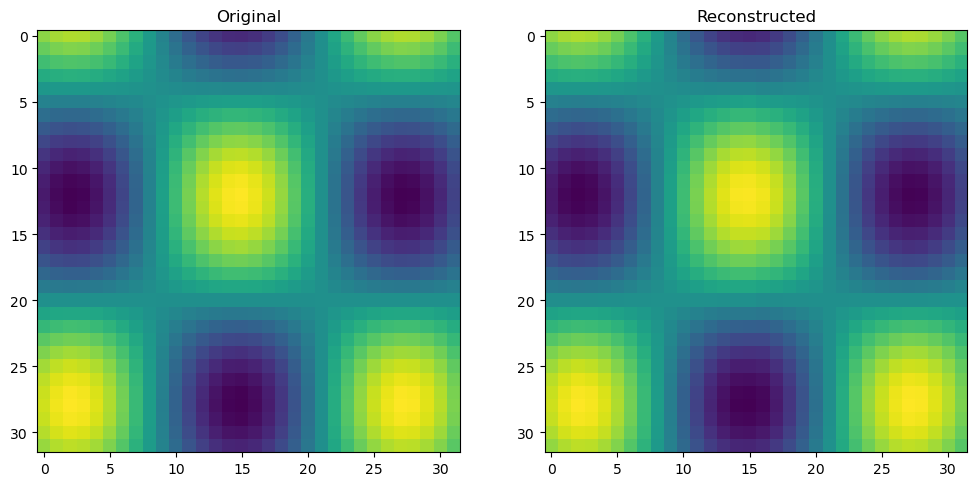

In [122]:
# Plot original and reconstructed signals for a sample
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(data[0], cmap="viridis")
axes[0].set_title("Original")
axes[1].imshow(reconstructed[0], cmap="viridis")
axes[1].set_title("Reconstructed")
plt.show()

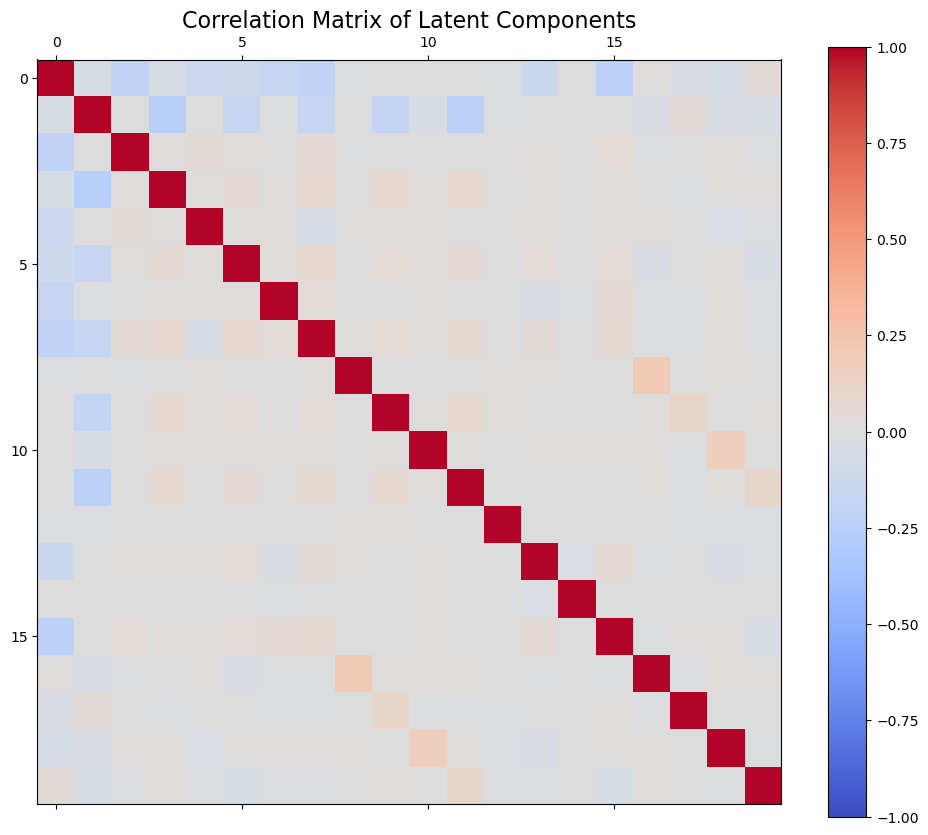

In [123]:
model.show_correlation_matrix(latents=latents[:, :20])

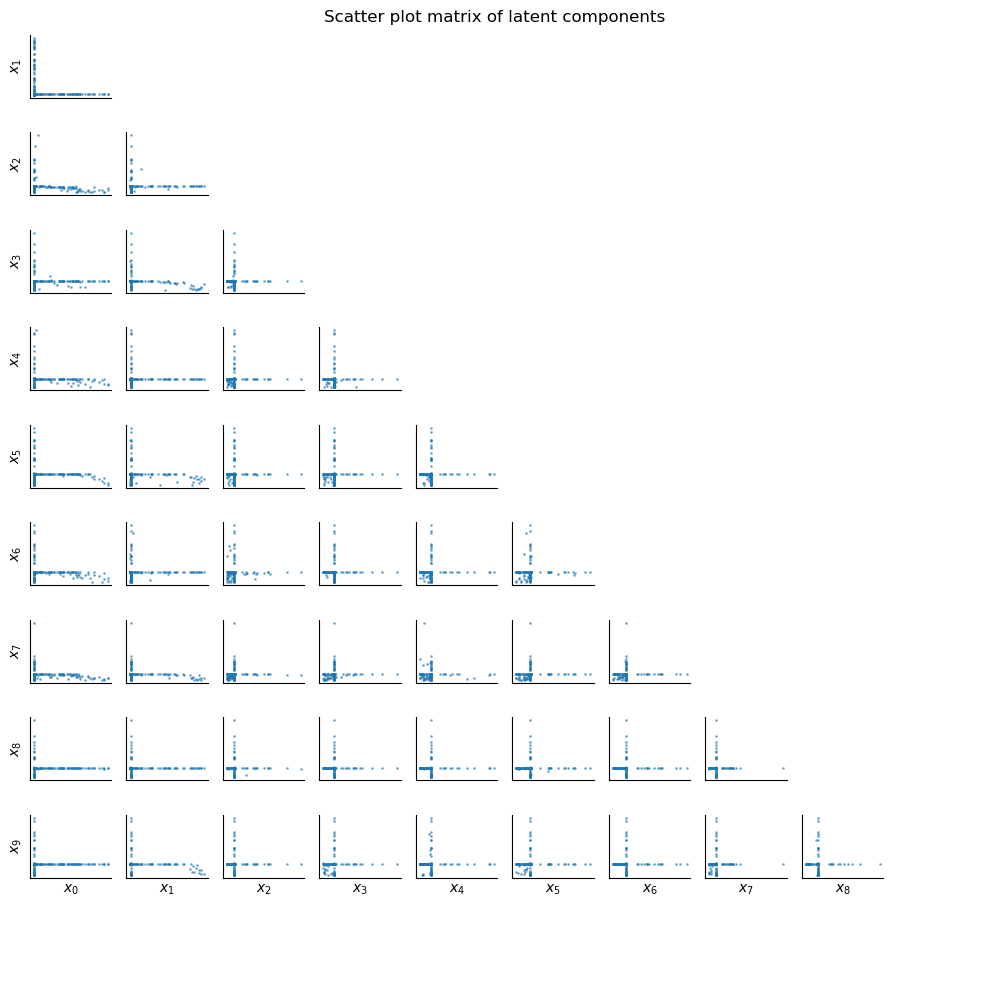

In [124]:
model.plot_scatter_corr_matrix(latents, n_components=10)

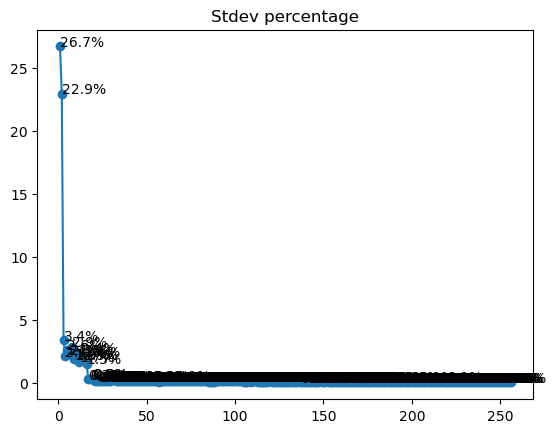

In [125]:
model.plot_stdev_pct()

(1) reconstruction error: 0.2486, variance: 0.2%, with      1  active latent components
(2) reconstruction error: 0.2487, variance: 0.2%, with      2  active latent components
(3) reconstruction error: 0.2487, variance: 0.2%, with      3  active latent components
(4) reconstruction error: 0.2487, variance: 0.2%, with      4  active latent components
(5) reconstruction error: 0.2487, variance: 0.2%, with      5  active latent components
(6) reconstruction error: 0.2487, variance: 0.2%, with      6  active latent components
(7) reconstruction error: 0.2487, variance: 0.2%, with      7  active latent components
(8) reconstruction error: 0.2487, variance: 0.2%, with      8  active latent components
(9) reconstruction error: 0.2487, variance: 0.2%, with      9  active latent components
(10) reconstruction error: 0.2487, variance: 0.2%, with     10  active latent components
(11) reconstruction error: 0.2487, variance: 0.2%, with     11  active latent components
(12) reconstruction error: 0.2

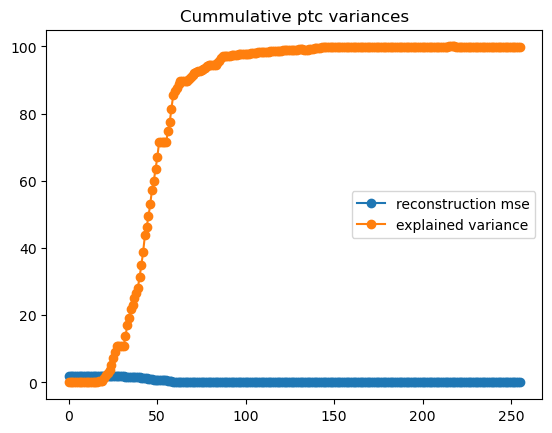

In [126]:
model.plot_cumsum_variance(data)

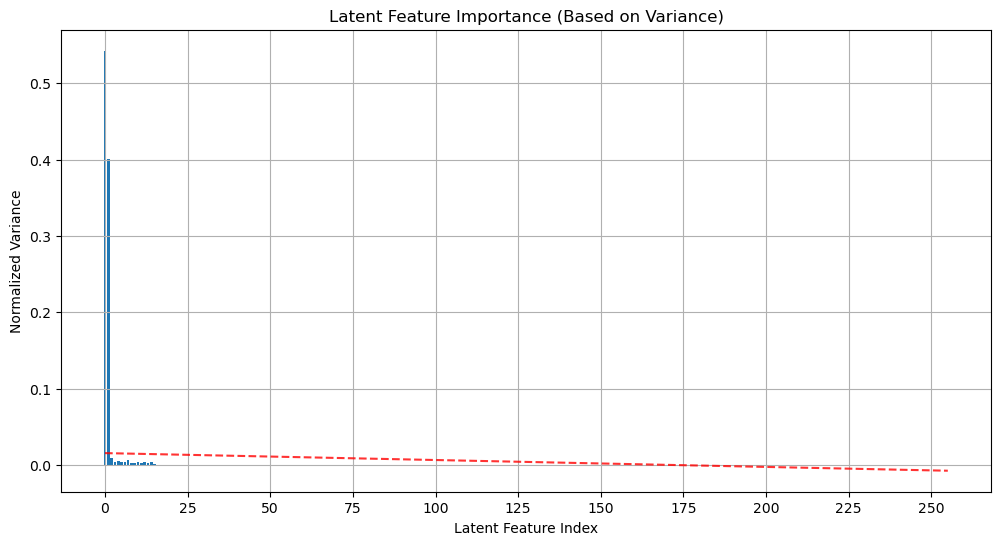

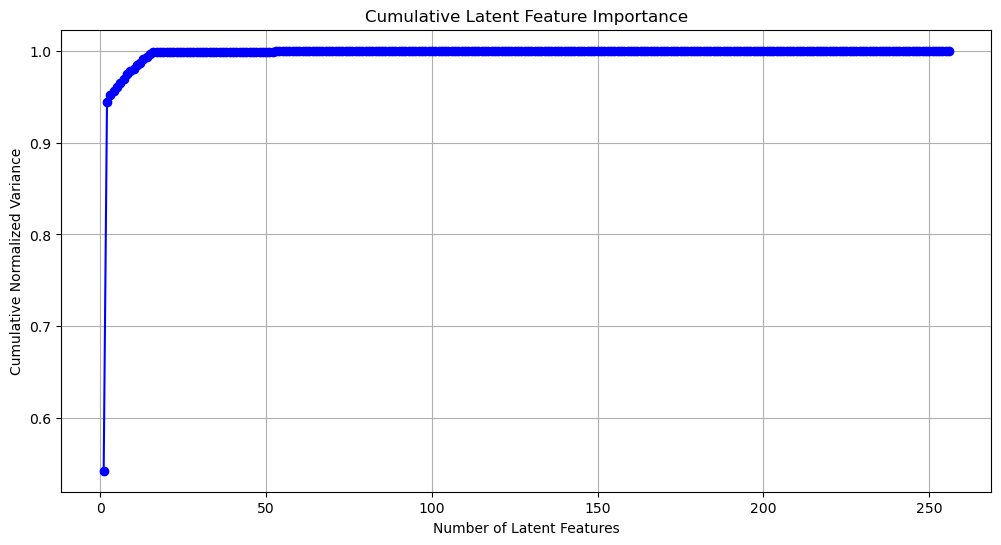

First feature importance: 0.5428
Last feature importance: 0.0000
Ratio of first to last feature importance: 1346600.1250
Number of features explaining 80% of the variance: 2
Intrinsic Dimension: 4.39


In [127]:
model.analyze_latent_feature_importance(data)

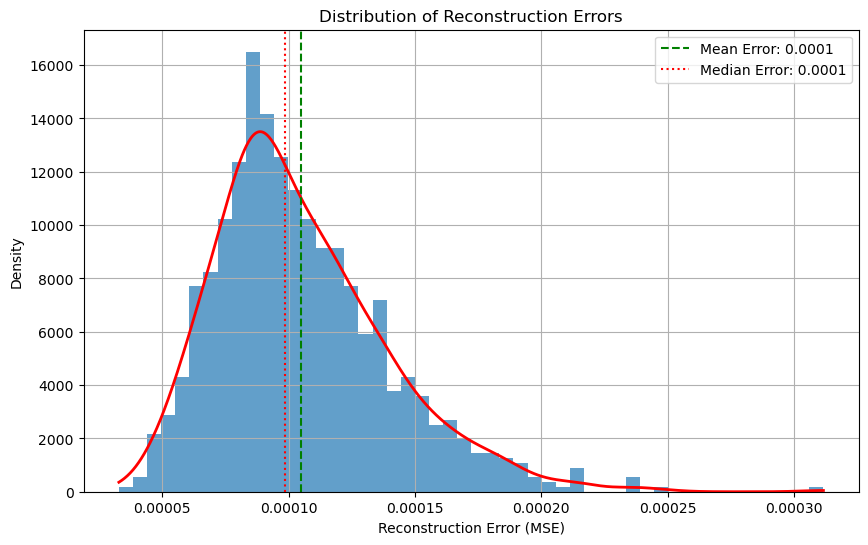

Mean Reconstruction Error: 0.0001
Median Reconstruction Error: 0.0001
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0003


In [128]:
model.analyze_reconstruction_error(data, n_samples=10000)

In [129]:
model.analyze_latent_space(data=data)


           Latent Space Analysis Report           

1. General Information
------------------------------
Number of latent components: 256
Total variance in latent space: 0.9010

2. Variance Analysis
------------------------------
Metric                           Value
-----------------------------  -------
First component                 0.5428
First 5 components              0.9609
Components for 95% variance     3
Variance Concentration Metric   0.9964

Variance Concentration Interpretation:
Excellent concentration of variance in earlier dimensions.

3. Orthogonality Analysis
------------------------------
Metric                                 Value
-----------------------------------  -------
Mean absolute off-diagonal            0.0518
Median absolute off-diagonal          0.0401
Max absolute off-diagonal             0.5
Proportion of |Orthogonality| > 0.1   0.127
Orthogonality Success Metric          0.9482

Orthogonality Interpretation:
Excellent orthogonality of features.

4.


    Orthogonality Test Analysis
    
    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 100 randomly selected data points for the analysis.
    
    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:
    
    - Mean cosine similarity: 0.0004
    - Max cosine similarity: 0.9489
    - Min cosine similarity: -0.9299
    


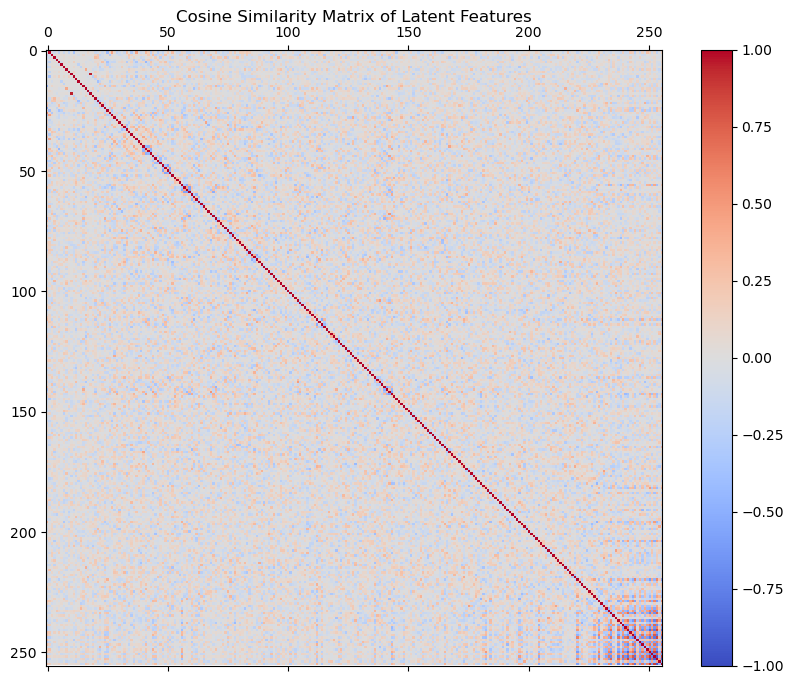

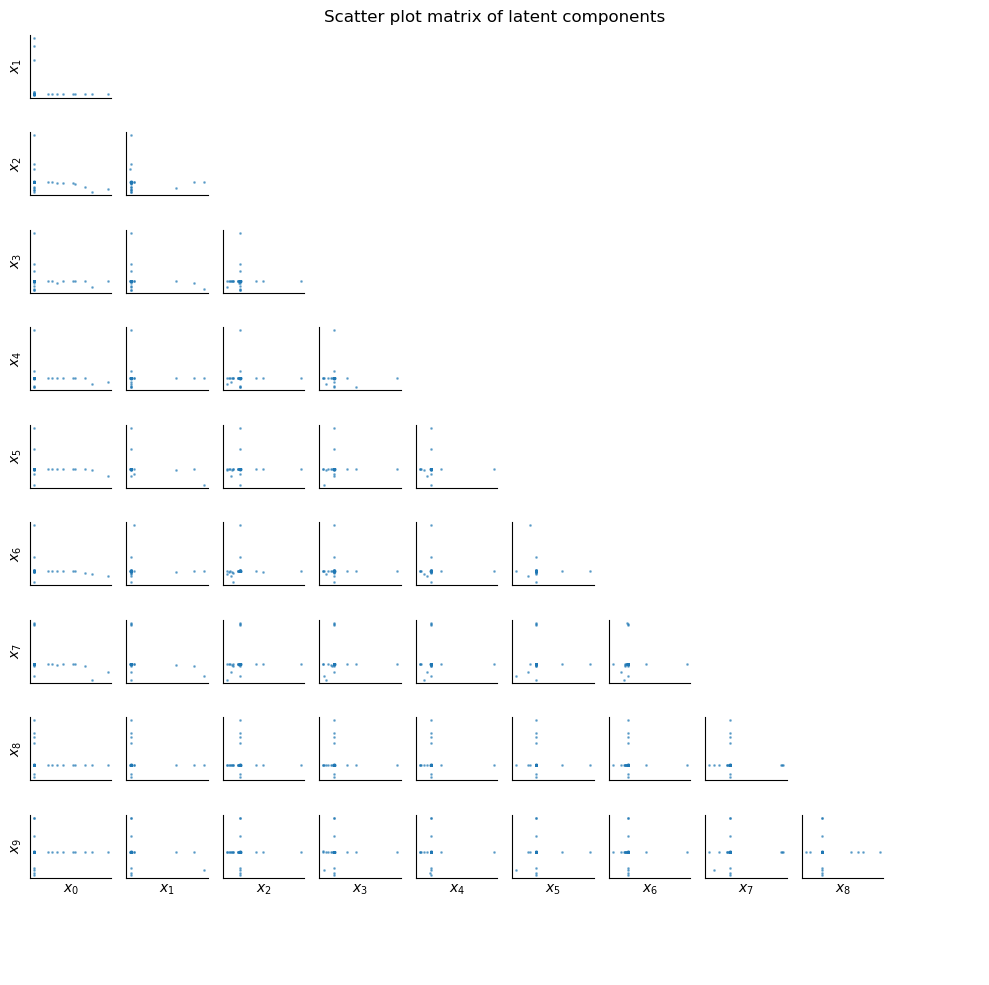

In [130]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def orthogonality_test_analysis(model, data, num_samples=100, n_components=10):
    """
    Analyze the orthogonality of the latent features of the autoencoder.

    Parameters:
    - model: The autoencoder model instance
    - data: Input data (numpy array)
    - num_samples: Number of samples to test (default: 100)
    - n_components: Number of components to plot in the scatter correlation matrix
    """
    # Select random samples from the data
    indices = np.random.choice(data.shape[0], num_samples, replace=False)
    x_samples = data[indices]

    # Encode the samples
    latent_x = model.encode(x_samples)

    # Calculate cosine similarity matrix
    cosine_sim = cosine_similarity(latent_x.T)

    # Extract the upper triangular part of the similarity matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(cosine_sim, k=1)
    upper_triangular_values = cosine_sim[upper_triangular_indices]

    # Reporting text with statistics
    report = f"""
    Orthogonality Test Analysis
    ============================
    
    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of {num_samples} randomly selected data points for the analysis.
    
    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:
    
    - Mean cosine similarity: {np.mean(upper_triangular_values):.4f}
    - Max cosine similarity: {np.max(upper_triangular_values):.4f}
    - Min cosine similarity: {np.min(upper_triangular_values):.4f}
    """

    print(report)

    # Plot cosine similarity matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(cosine_sim, cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ax.set_title('Cosine Similarity Matrix of Latent Features', pad=20)
    plt.show()

    # Plot scatter correlation matrix
    model.plot_scatter_corr_matrix(latents=latent_x, n_components=n_components)

# Example usage
# Assuming `polcanet_model` is an instance of PolcaNet and `data` is the input data.
orthogonality_test_analysis(model, data)



    Variance Test Analysis
    
    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 100 randomly selected data points for the analysis.
    
    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:
    
    - Center of mass: 1.9048
    - Variance fit to exponential distribution (sum of squared differences): 0.0959
    


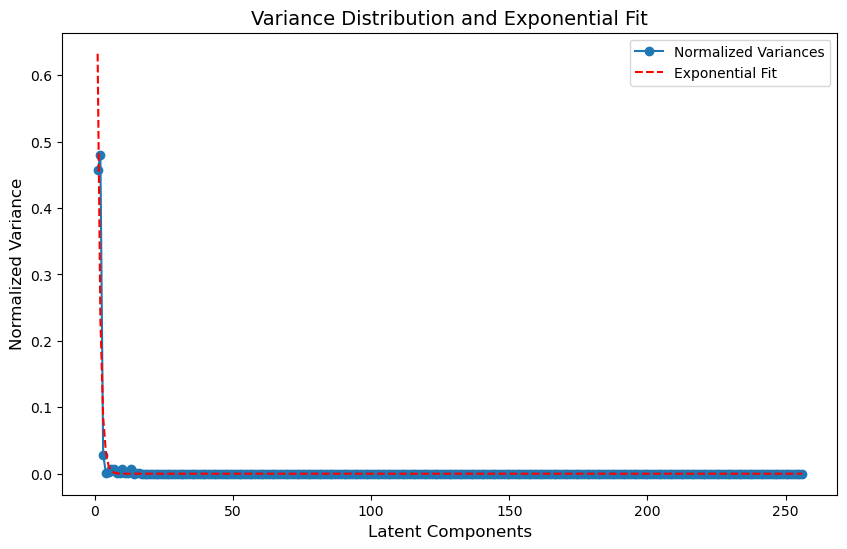

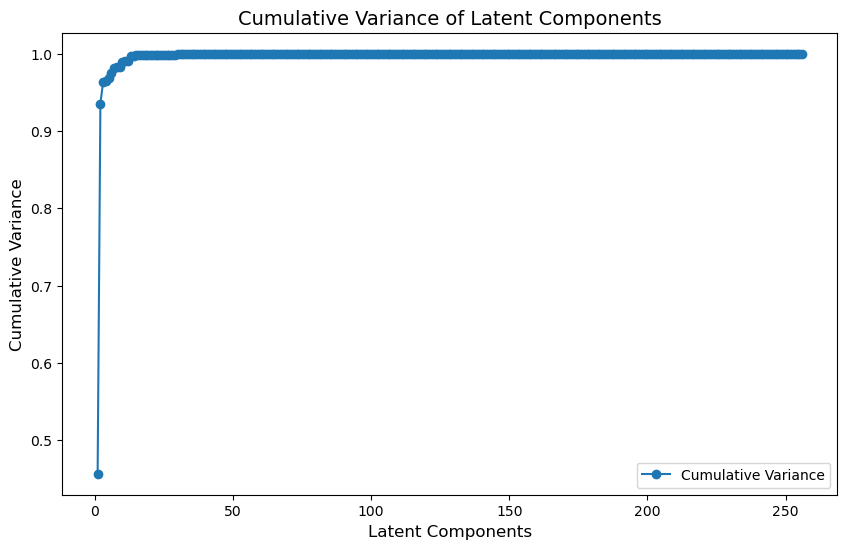

Top 20 Components Variance Analysis:
Component 1: Normalized Variance = 0.4565, Cumulative Variance = 0.4565
Component 2: Normalized Variance = 0.4790, Cumulative Variance = 0.9354
Component 3: Normalized Variance = 0.0285, Cumulative Variance = 0.9639
Component 4: Normalized Variance = 0.0014, Cumulative Variance = 0.9653
Component 5: Normalized Variance = 0.0028, Cumulative Variance = 0.9682
Component 6: Normalized Variance = 0.0071, Cumulative Variance = 0.9753
Component 7: Normalized Variance = 0.0066, Cumulative Variance = 0.9819
Component 8: Normalized Variance = 0.0006, Cumulative Variance = 0.9825
Component 9: Normalized Variance = 0.0005, Cumulative Variance = 0.9830
Component 10: Normalized Variance = 0.0066, Cumulative Variance = 0.9897
Component 11: Normalized Variance = 0.0004, Cumulative Variance = 0.9901
Component 12: Normalized Variance = 0.0004, Cumulative Variance = 0.9905
Component 13: Normalized Variance = 0.0065, Cumulative Variance = 0.9970
Component 14: Normalize

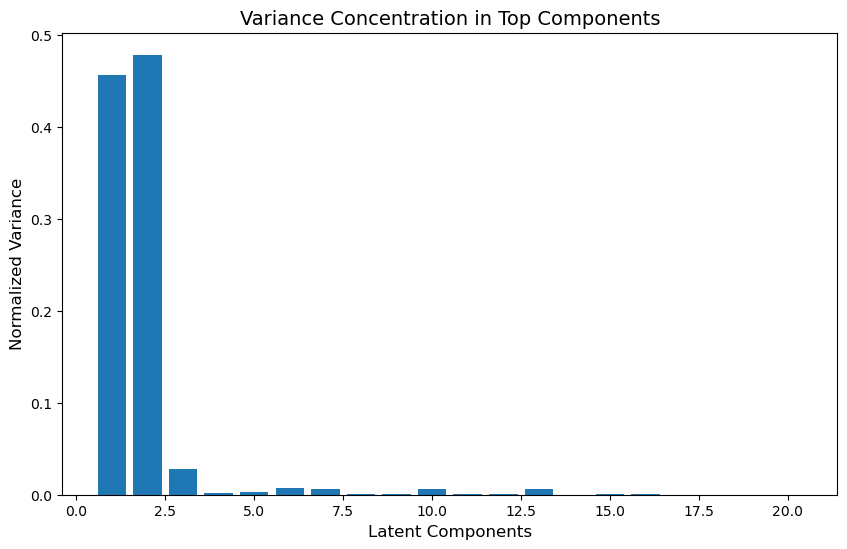

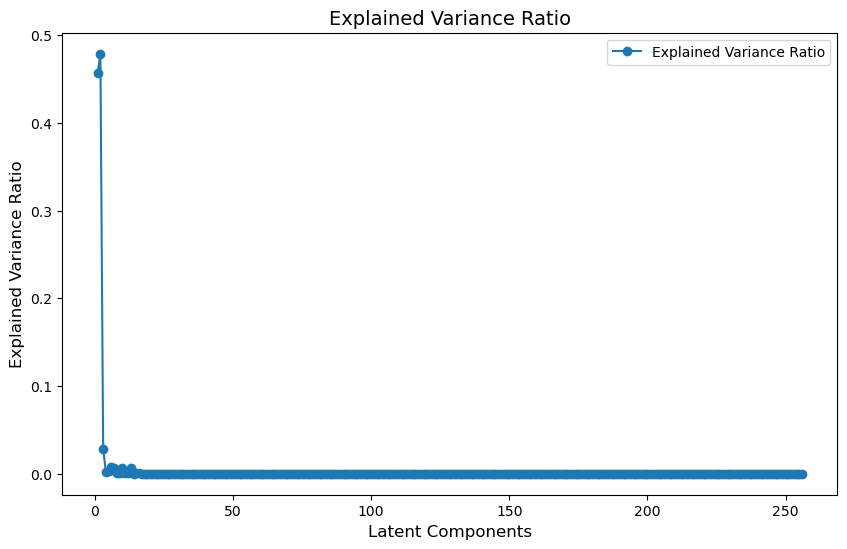

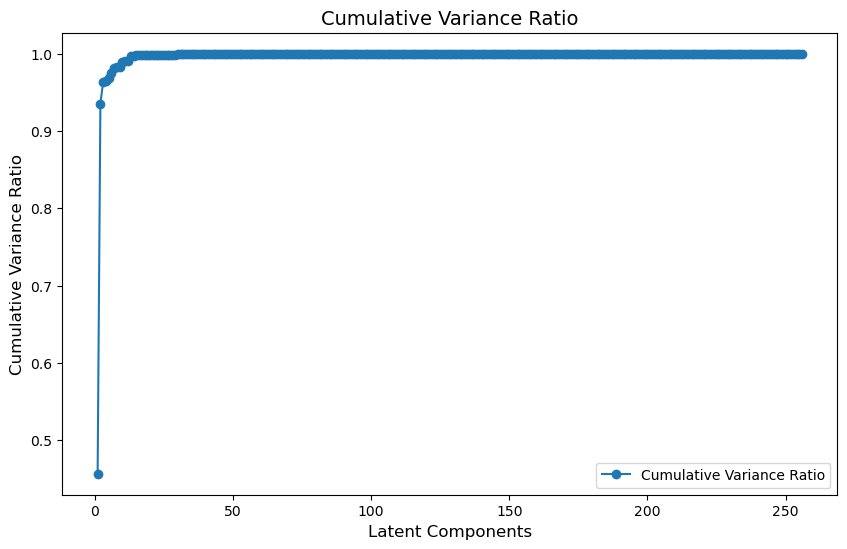

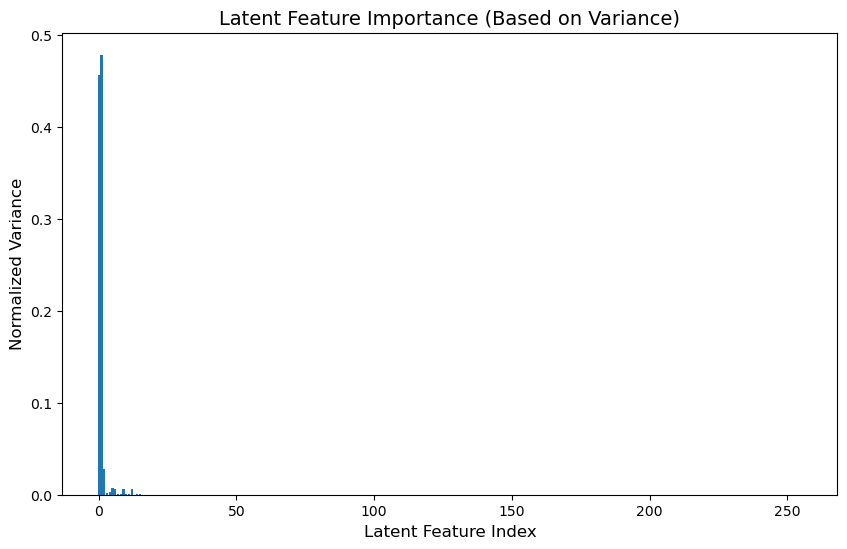

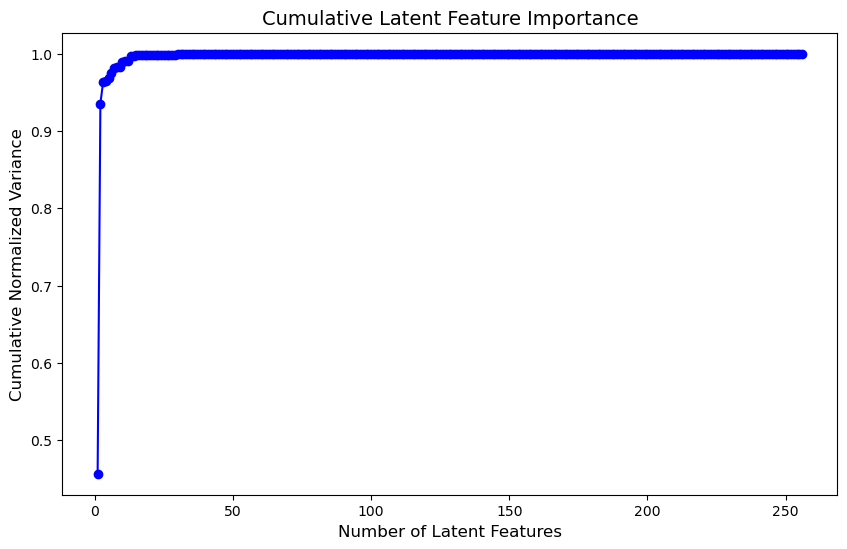

In [131]:
import matplotlib.pyplot as plt
import numpy as np

def variance_test_analysis(model, data, num_samples=100):
    """
    Analyze the variance concentration of the latent features of the autoencoder.

    Parameters:
    - model: The autoencoder model instance
    - data: Input data (numpy array)
    - num_samples: Number of samples to test (default: 100)
    """
    # Select random samples from the data
    indices = np.random.choice(data.shape[0], num_samples, replace=False)
    x_samples = data[indices]

    # Encode the samples
    latent_x = model.encode(x_samples)

    # Calculate variances of the latent features
    variances = np.var(latent_x, axis=0)

    # Calculate center of mass
    components = np.arange(1, len(variances) + 1)
    center_of_mass = np.sum(components * variances) / np.sum(variances)

    # Calculate exponential fit for variance
    normalized_variances = variances / np.sum(variances)
    exp_fit = np.exp(-components)
    exp_fit /= np.sum(exp_fit)

    # Explained Variance Ratio
    explained_variance_ratio = variances / np.sum(variances)

    # Cumulative Variance Ratio
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    # Reporting text with statistics
    report = f"""
    Variance Test Analysis
    =======================
    
    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of {num_samples} randomly selected data points for the analysis.
    
    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:
    
    - Center of mass: {center_of_mass:.4f}
    - Variance fit to exponential distribution (sum of squared differences): {np.sum((normalized_variances - exp_fit) ** 2):.4f}
    """

    print(report)

    # Plot variance distribution and exponential fit
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(components, normalized_variances, 'o-', label='Normalized Variances')
    ax.plot(components, exp_fit, 'r--', label='Exponential Fit')
    ax.set_title('Variance Distribution and Exponential Fit', fontsize=14)
    ax.set_xlabel('Latent Components', fontsize=12)
    ax.set_ylabel('Normalized Variance', fontsize=12)
    ax.legend()
    plt.show()

    # Plot cumulative variance
    cumulative_variance = np.cumsum(normalized_variances)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(components, cumulative_variance, 'o-', label='Cumulative Variance')
    ax.set_title('Cumulative Variance of Latent Components', fontsize=14)
    ax.set_xlabel('Latent Components', fontsize=12)
    ax.set_ylabel('Cumulative Variance', fontsize=12)
    ax.legend()
    plt.show()

    # Analyze and plot variance concentration
    top_n = min(20, len(variances))  # Analyze top 20 components or all if less than 10
    component_table = []
    for i in range(top_n):
        component_table.append([i + 1, f"{normalized_variances[i]:.4f}", f"{cumulative_variance[i]:.4f}"])

    report_table = "\n".join([f"Component {row[0]}: Normalized Variance = {row[1]}, Cumulative Variance = {row[2]}" for row in component_table])
    print(f"Top {top_n} Components Variance Analysis:\n{report_table}")

    # Plot variance concentration in top components
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(range(1, top_n + 1), normalized_variances[:top_n])
    ax.set_title('Variance Concentration in Top Components', fontsize=14)
    ax.set_xlabel('Latent Components', fontsize=12)
    ax.set_ylabel('Normalized Variance', fontsize=12)
    plt.show()

    # Plot Explained Variance Ratio
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(components, explained_variance_ratio, 'o-', label='Explained Variance Ratio')
    ax.set_title('Explained Variance Ratio', fontsize=14)
    ax.set_xlabel('Latent Components', fontsize=12)
    ax.set_ylabel('Explained Variance Ratio', fontsize=12)
    ax.legend()
    plt.show()

    # Plot Cumulative Variance Ratio
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(components, cumulative_variance_ratio, 'o-', label='Cumulative Variance Ratio')
    ax.set_title('Cumulative Variance Ratio', fontsize=14)
    ax.set_xlabel('Latent Components', fontsize=12)
    ax.set_ylabel('Cumulative Variance Ratio', fontsize=12)
    ax.legend()
    plt.show()

    # Plot Latent Feature Importance (Based on Variance)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(range(len(explained_variance_ratio)), explained_variance_ratio)
    ax.set_title('Latent Feature Importance (Based on Variance)', fontsize=14)
    ax.set_xlabel('Latent Feature Index', fontsize=12)
    ax.set_ylabel('Normalized Variance', fontsize=12)
    plt.show()

    # Plot Cumulative Latent Feature Importance
    cumulative_importance = np.cumsum(explained_variance_ratio)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'bo-')
    ax.set_title('Cumulative Latent Feature Importance', fontsize=14)
    ax.set_xlabel('Number of Latent Features', fontsize=12)
    ax.set_ylabel('Cumulative Normalized Variance', fontsize=12)
    plt.show()

# Example usage
# Assuming `polcanet_model` is an instance of PolcaNet and `data` is the input data.
variance_test_analysis(model, data)



    Linearity Tests Analysis
    
    This report analyzes the linearity properties of the autoencoder. We used a sample size of 
    100 randomly selected data points for the analysis.
    
    The linearity properties of the features are assessed through two tests: additive property 
    and homogeneity property. The results are summarized below:
    
    1. Additive Property:
    ---------------------
    The additive property is tested to verify if:
    
    f(z(x) + z(y)) = f(z(x)) + f(z(y))
    
    The differences between the left-hand side and the right-hand side of the equation are 
    summarized below:
    
    - Mean difference: 0.0038
    - Max difference: 0.0238
    - Min difference: 0.0000
    
    2. Homogeneity Property (Scalar alpha):
    ---------------------------------------
    The homogeneity property is tested to verify if:
    
    f(a.z(x)) = a.f(z(x))
    
    The differences between the left-hand side and the right-hand side of the equation are 
    summari

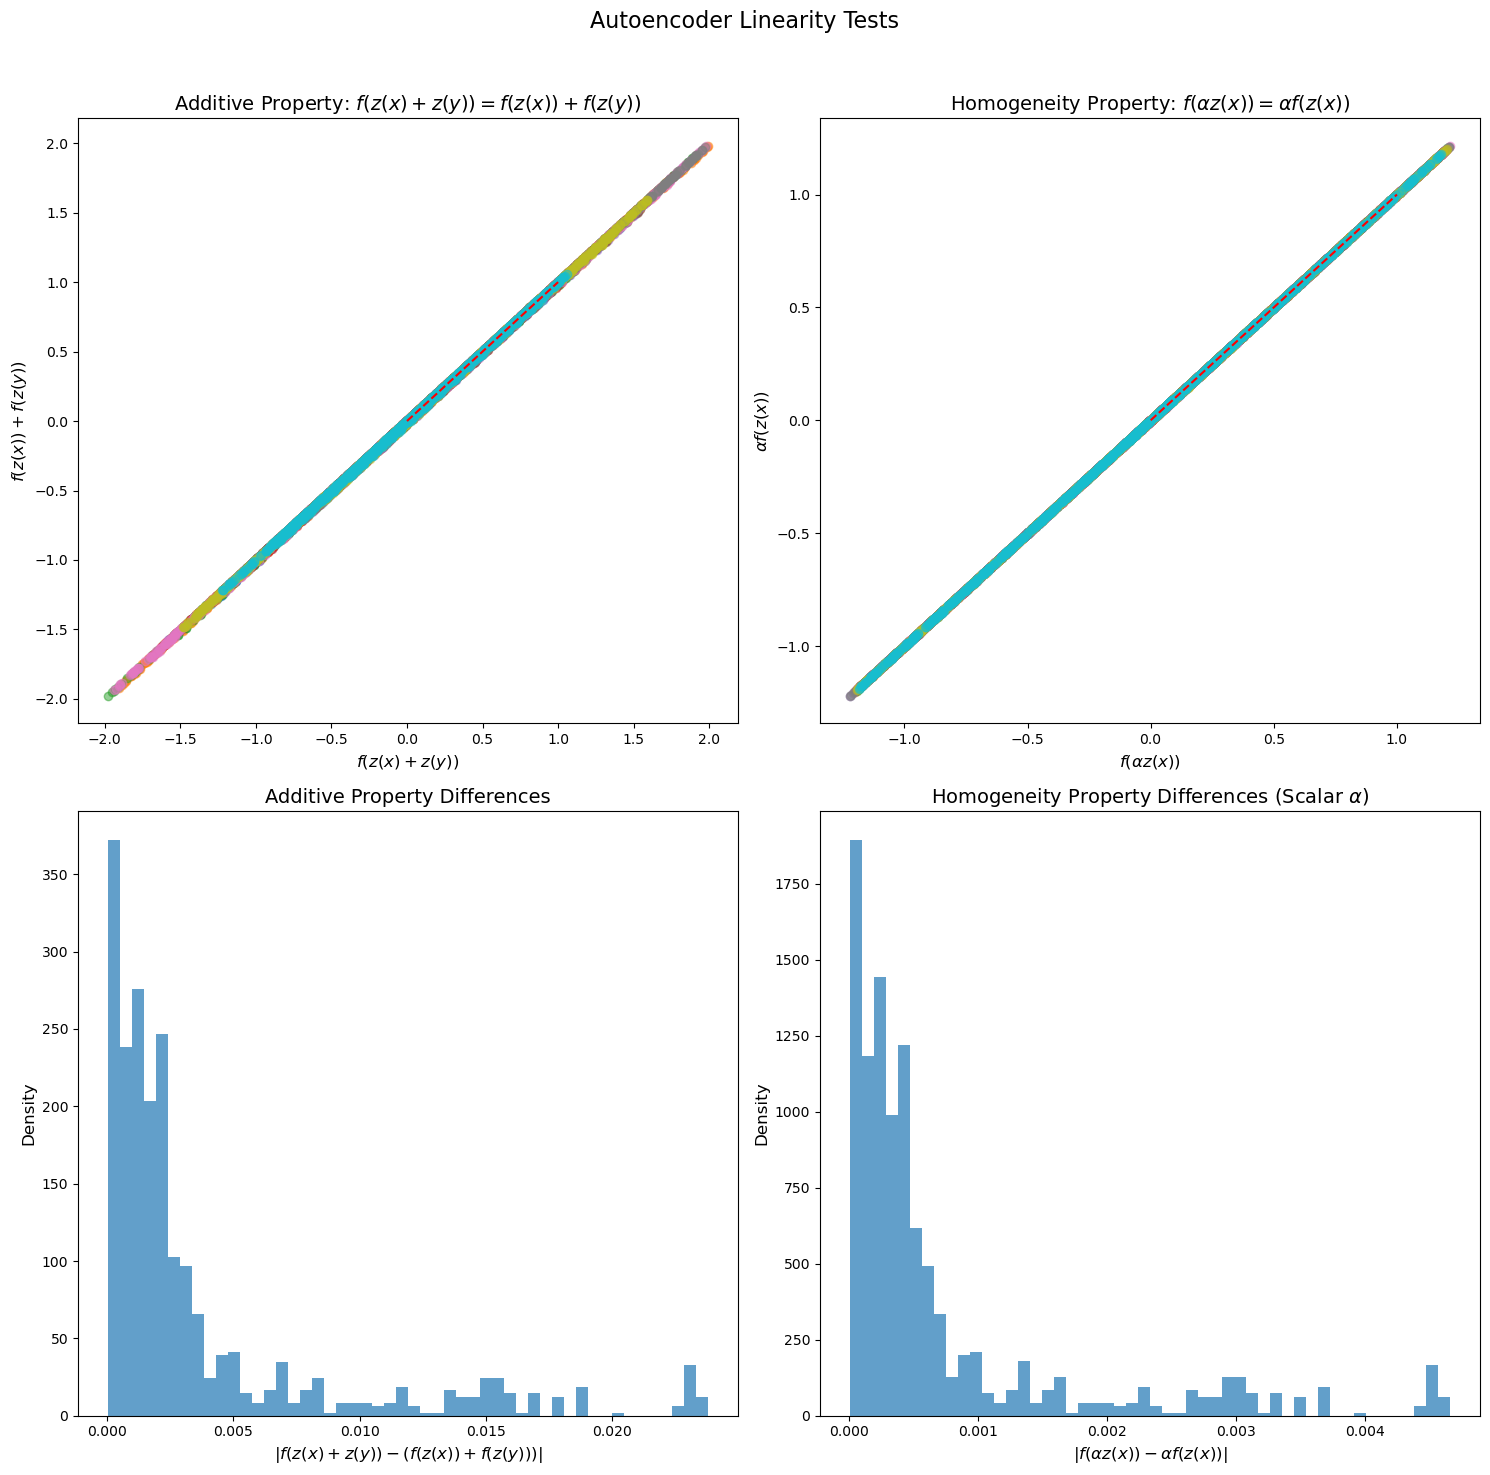

In [132]:
import matplotlib.pyplot as plt
import numpy as np

def linearity_tests_analysis(model, data, num_samples=100):
    """
    Analyze the linearity properties of the autoencoder.

    Parameters:
    - model: The autoencoder model instance
    - data: Input data (numpy array)
    - num_samples: Number of samples to test (default: 100)
    """
    # Select random samples from the data
    indices = np.random.choice(data.shape[0], num_samples, replace=False)
    x_samples = data[indices]
    y_samples = data[np.random.choice(data.shape[0], num_samples, replace=False)]

    # Encode the samples
    latent_x = model.encode(x_samples)
    latent_y = model.encode(y_samples)

    # Additive property test
    latent_x_plus_y = latent_x + latent_y
    decoded_latent_x_plus_y = model.decode(latent_x_plus_y)
    decoded_latent_x = model.decode(latent_x)
    decoded_latent_y = model.decode(latent_y)
    decoded_latent_x_plus_decoded_latent_y = decoded_latent_x + decoded_latent_y

    # Homogeneity property test with scalar alpha
    alpha_scalar = np.random.uniform(0.1, 2.0)  # Random scalar value
    latent_alpha_x_scalar = alpha_scalar * latent_x
    decoded_latent_alpha_x_scalar = model.decode(latent_alpha_x_scalar)
    alpha_decoded_latent_x_scalar = alpha_scalar * decoded_latent_x

    # Calculate differences for reporting
    differences_additive = np.abs(decoded_latent_x_plus_y - decoded_latent_x_plus_decoded_latent_y)
    differences_homogeneity_scalar = np.abs(decoded_latent_alpha_x_scalar - alpha_decoded_latent_x_scalar)

    # Reporting text with statistics
    report = f"""
    Linearity Tests Analysis
    =========================
    
    This report analyzes the linearity properties of the autoencoder. We used a sample size of 
    {num_samples} randomly selected data points for the analysis.
    
    The linearity properties of the features are assessed through two tests: additive property 
    and homogeneity property. The results are summarized below:
    
    1. Additive Property:
    ---------------------
    The additive property is tested to verify if:
    
    f(z(x) + z(y)) = f(z(x)) + f(z(y))
    
    The differences between the left-hand side and the right-hand side of the equation are 
    summarized below:
    
    - Mean difference: {np.mean(differences_additive):.4f}
    - Max difference: {np.max(differences_additive):.4f}
    - Min difference: {np.min(differences_additive):.4f}
    
    2. Homogeneity Property (Scalar alpha):
    ---------------------------------------
    The homogeneity property is tested to verify if:
    
    f(a.z(x)) = a.f(z(x))
    
    The differences between the left-hand side and the right-hand side of the equation are 
    summarized below:
    
    - Mean difference: {np.mean(differences_homogeneity_scalar):.4f}
    - Max difference: {np.max(differences_homogeneity_scalar):.4f}
    - Min difference: {np.min(differences_homogeneity_scalar):.4f}
    """

    print(report)

    # Plot results
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle(r"Autoencoder Linearity Tests", fontsize=16)

    # Additive property plot
    for i in range(10):  # Plot first 10 samples
        axs[0, 0].scatter(decoded_latent_x_plus_y[i].flatten(), decoded_latent_x_plus_decoded_latent_y[i].flatten(), alpha=0.5)
    axs[0, 0].plot([0, 1], [0, 1], 'r--')
    axs[0, 0].set_title(r"Additive Property: $f(z(x) + z(y)) = f(z(x)) + f(z(y))$", fontsize=14)
    axs[0, 0].set_xlabel(r"$f(z(x) + z(y))$", fontsize=12)
    axs[0, 0].set_ylabel(r"$f(z(x)) + f(z(y))$", fontsize=12)

    # Homogeneity property plot (scalar alpha)
    for i in range(10):  # Plot first 10 samples
        axs[0, 1].scatter(decoded_latent_alpha_x_scalar[i].flatten(), alpha_decoded_latent_x_scalar[i].flatten(), alpha=0.5)
    axs[0, 1].plot([0, 1], [0, 1], 'r--')
    axs[0, 1].set_title(r"Homogeneity Property: $f(\alpha z(x)) = \alpha f(z(x))$", fontsize=14)
    axs[0, 1].set_xlabel(r"$f(\alpha z(x))$", fontsize=12)
    axs[0, 1].set_ylabel(r"$\alpha f(z(x))$", fontsize=12)

    # Difference plots for additive property
    axs[1, 0].hist(differences_additive.flatten(), bins=50, density=True, alpha=0.7)
    axs[1, 0].set_title(r"Additive Property Differences", fontsize=14)
    axs[1, 0].set_xlabel(r"$|f(z(x) + z(y)) - (f(z(x)) + f(z(y)))|$", fontsize=12)
    axs[1, 0].set_ylabel("Density", fontsize=12)

    # Difference plots for homogeneity property (scalar alpha)
    axs[1, 1].hist(differences_homogeneity_scalar.flatten(), bins=50, density=True, alpha=0.7)
    axs[1, 1].set_title(r"Homogeneity Property Differences (Scalar $\alpha$)", fontsize=14)
    axs[1, 1].set_xlabel(r"$|f(\alpha z(x)) - \alpha f(z(x))|$", fontsize=12)
    axs[1, 1].set_ylabel("Density", fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage
# Assuming `polcanet_model` is an instance of PolcaNet and `data` is the input data.
linearity_tests_analysis(model, data)
